In [57]:
import torch
# Config data

DATA_DIR = 'data/'
CHECKPOINT_DIR = 'checkpoints/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 64
epochs = 24
lr = 0.001

In [58]:
import os
import pandas as pd
from torchvision import transforms
from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.utils.data import DataLoader

# Dataset definition
class ImageNet_Challenge_Dataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, str(self.img_labels.iloc[idx, 0]) + '.jpg')
        image = read_image(img_path) / 255
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

# Preprocess and DataLoader
preprocess = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip()
    ])
training_data = ImageNet_Challenge_Dataset(DATA_DIR + 'train.csv', DATA_DIR + 'train', transform=preprocess, target_transform=lambda x : x-1)
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)

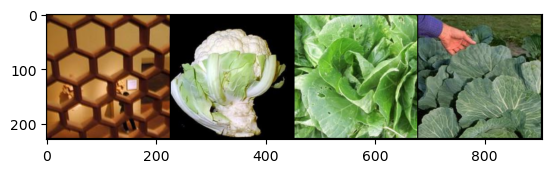

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision

# Show example images
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  

inputs, classes = next(iter(train_dataloader))
out = torchvision.utils.make_grid(inputs[:4])
imshow(out)

In [60]:
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

# Define custom model
model = resnet50(weights=ResNet50_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)
model = model.to(device)

# Loss function, optimizer and scheduler
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [61]:
import time
from tqdm import tqdm

# Train loop
losses = []
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_acc = 0.0
    best_epoch = 0
    
    for idx, epoch in enumerate(range(num_epochs)):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)
        
        model.train()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in tqdm(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        scheduler.step()
        
        epoch_loss = running_loss / len(training_data)
        epoch_acc = running_corrects.double() / len(training_data)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
        torch.save(model.state_dict(), CHECKPOINT_DIR + 'snapshot' + str(epoch) + '.pt')

        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_epoch = idx

    print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f} in epoch: {best_epoch}')

In [ ]:
train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
            num_epochs=epochs)

Epoch 1/24
----------


100%|██████████| 63/63 [04:11<00:00,  4.00s/it]


Loss: 0.9623 Acc: 0.7598
Epoch 2/24
----------


100%|██████████| 63/63 [03:55<00:00,  3.73s/it]


Loss: 0.3846 Acc: 0.9175
Epoch 3/24
----------


  2%|▏         | 1/63 [00:03<03:52,  3.75s/it]

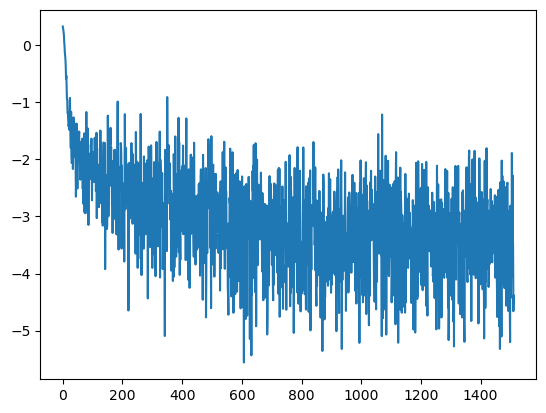

In [10]:
# Log Loss Plot, log function used for readability
plt.plot(range(len(losses)), np.log(losses))

In [52]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

model = resnet50(weights=ResNet50_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)
model = model.to('cuda:0')

checkpoint = torch.load('checkpoints/snapshot20.pt')
model.load_state_dict(checkpoint)
model.eval()

y_pred = []
y_true = []
for inputs, labels in train_dataloader:
    inputs = inputs.to('cuda:0')
    output = model(inputs)
    _, pred = torch.max(output, 1)
    y_pred.extend(pred.detach().cpu().numpy())
    y_true.extend(labels.detach().cpu().numpy())

epoch_acc = accuracy_score(y_pred, y_true)
epoch_prec = precision_score(y_pred, y_true, average='macro')
epoch_recall = recall_score(y_pred, y_true, average='macro')
epoch_f1 = f1_score(y_pred, y_true, average='macro')

print(f'Epoch Metrics - Acc: {epoch_acc:4f} Prec: {epoch_prec:4f} Recall: {epoch_recall:4f} F1-Score: {epoch_f1:4f}')

Epoch Metrics - Acc: 0.987750 Prec: 0.987706 Recall: 0.987740 F1-Score: 0.987722


<Axes: >

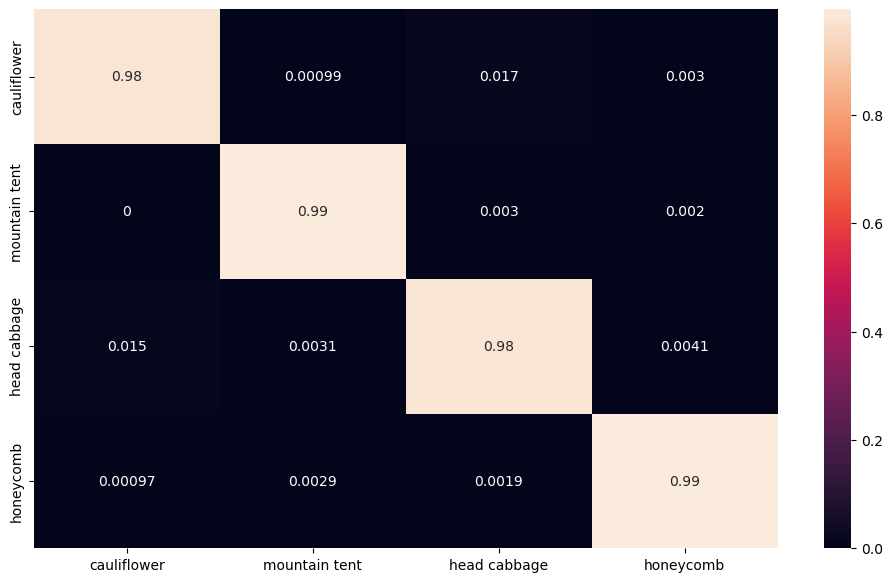

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

classes = ('cauliflower', 'mountain tent', 
           'head cabbage', 'honeycomb')

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)